In [1]:
# data analysis
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# visualization
import matplotlib.pyplot as plt

# machine learning model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# ETC
import warnings
from pprint import pprint
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 1. 데이터 로드 및 설명 

* u_forecast : 울산 지역의 일기예보 정보 
* u_weather : 울산 지역의 실제 날씨 정보 
* d_forecast : 당진 지역의 일기예보 정보
* d_weather : 당진 지역의 실제 날씨 정보 
* energy : 2018년 3월 1일 ~ 2021년 1월 31일까지 울산 및 당진에서의 발전량 

본 task의 목적은 2021년 3월 1일까지의 기상 예보 정보가 주어진 상황에서 2021년 2월달의 전기 발전량을 예측하는 것이다.  
직접적인 날씨 정보가 주어지는 것이 아니기 때문에 일기예보를 통해 
1. 날씨 예측
2. 발전량 예측 
의 순서로 갈지, 아니면 일기예보로부터 직접 발전량을 예측할 지 결정을 해야한다.  
   
본 전처리를 통해 변수간의 상관관계를 살펴보고 발전량과 상관관계, 인과관계가 높은 변수를 추출하고자 한다. 

In [2]:
u_weather = pd.read_csv('data/ulsan_obs_data.csv')
u_forecast = pd.read_csv('data/ulsan_fcst_data.csv')
d_weather = pd.read_csv('data/dangjin_obs_data.csv')
d_forecast = pd.read_csv('data/dangjin_fcst_data.csv')

energy = pd.read_csv('data/energy.csv')

In [3]:
u_weather.head()

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,152,울산,2018-03-01 00:00,8.2,3.9,340.0,98.0,10.0
1,152,울산,2018-03-01 01:00,7.0,4.1,320.0,97.0,10.0
2,152,울산,2018-03-01 02:00,6.5,5.9,290.0,80.0,NaN
3,152,울산,2018-03-01 03:00,6.2,4.6,320.0,79.0,3.0
4,152,울산,2018-03-01 04:00,6.7,4.5,320.0,73.0,1.0


In [4]:
u_forecast.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0


In [5]:
energy.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0


* energy는 time을 제외하고 당진, 당진 웨어하우스, 당진 프로팅 당진관련 발전량 데이터 3개, 울산 관련 발전량 데이터 1개, 총 4개의 column이 존재한다. 데이터의 가독성을 높여주기 위해 "당진 에너지" 데이터 프레임과 "울산 에너지" 데이터 프레임으로 분류 해준다. 

In [6]:
d_energy, u_energy = energy.iloc[ : , : -1], energy[['time', 'ulsan']]

# 2. 데이터 탐색

* 날씨 데이터를 직접 살펴보면서 이상치나 결측치, 발전량에 유의미한 영향을 미칠것으로 예상되는 변수에 대한 가설설정과 같은 과정을 진행하였다. 

In [7]:
def check_unique_value(data) :
    columns = data.columns 
    for col in columns :
        print('column : {}, unique value : {}'.format(col, np.unique(data[col])))
        
def fill_missing_value(data, columns) :
    for col in columns :
        try : 
            null_list = data[data[col].isnull()].index.tolist()
            data[col] = data[col].fillna(0)
            for null_idx in null_list :
                data.loc[null_idx, col] = (data.loc[null_idx-1, col] + data.loc[null_idx+1, col]) /2
                
        except : 
            print('There are no missing values in {} column'.format(col))
    
    return data

def trend_visualization(data, columns, region) :
    fig, axes = plt.subplots(len(columns), figsize=(16,20))
    
    for idx, col in enumerate(columns) :
        axes[idx].plot(data[col], label = col)
        #axes[idx].plot(data['smooth_' + col], label = 'smoothed' + col)
        axes[idx].plot(data[col + '_trend'], label = col + ' trend')
        #axes[idx].plot(data[col + '_seasonal'], label = col + ' seosonal')
        #axes[idx].plot(data[col + '_residual'], label = col + ' residual')
        axes[idx].set_title('trend of {}'.format(col))
        axes[idx].legend()
    fig.suptitle(region + ' plot ', fontsize=20)
    plt.show()
    
def time_derived_variable(data, column) :
    data[column] = pd.to_datetime(data[column])
    date_time = data[column].dt
    data['year'] = date_time.year
    data['month'] = date_time.month
    data['day'] = date_time.day
    data['hour'] = date_time.hour
    
    return data 

def data_smoothing(data, columns, window) :
    for col in columns : 
        new_feature  = 'smooth_' + col
        data[new_feature] = [0] * len(data)
        
        for row_idx, row in enumerate(data[col]) :
            if row_idx < window :
                data.loc[row_idx, new_feature] = 0
                
                for i in range(row_idx + 1) :
                    data.loc[row_idx, new_feature] += data.loc[row_idx-i, col]
                data.loc[row_idx, new_feature] = data.loc[row_idx, new_feature]/(row_idx + 1)

            else : 
                data.loc[row_idx, new_feature] = 0
                for j in range(window + 1) :
                    data.loc[row_idx, new_feature] += data.loc[row_idx - j, col]
                data.loc[row_idx, new_feature] = data.loc[row_idx, new_feature]/(window + 1)
                
    return data

def data_smoothing2(data, columns):
    output = { }
    
    for col in columns :
        decomposition = seasonal_decompose(data[col], model='additive')
        output[col + '_trend'] = decomposition.trend
        #output[col + '_seasonal'] = decomposition.seasonal
        #utput[col + '_residual'] = decomposition.resid
        
    return output

In [8]:
u_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [9]:
check_unique_value(u_weather)

column : 지점, unique value : [152]
column : 지점명, unique value : ['울산']
column : 일시, unique value : ['2018-03-01 00:00' '2018-03-01 01:00' '2018-03-01 02:00' ...
 '2021-01-31 21:00' '2021-01-31 22:00' '2021-01-31 23:00']
column : 기온(°C), unique value : [-12.  -11.9 -11.7 -11.6 -11.4 -11.1 -10.8 -10.6 -10.5 -10.4 -10.3 -10.2
 -10.   -9.8  -9.7  -9.6  -9.5  -9.4  -9.3  -9.1  -9.   -8.8  -8.6  -8.5
  -8.4  -8.2  -8.1  -8.   -7.9  -7.8  -7.7  -7.6  -7.5  -7.4  -7.3  -7.2
  -7.1  -7.   -6.8  -6.7  -6.6  -6.5  -6.4  -6.3  -6.2  -6.1  -6.   -5.9
  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3  -5.2  -5.1  -5.   -4.9  -4.8  -4.7
  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1  -4.   -3.9  -3.8  -3.7  -3.6  -3.5
  -3.4  -3.3  -3.2  -3.1  -3.   -2.9  -2.8  -2.7  -2.6  -2.5  -2.4  -2.3
  -2.2  -2.1  -2.   -1.9  -1.8  -1.7  -1.6  -1.5  -1.4  -1.3  -1.2  -1.1
  -1.   -0.9  -0.8  -0.7  -0.6  -0.5  -0.4  -0.3  -0.2  -0.1   0.    0.1
   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1   1.2   1.3
   1.4   1.5   1.6 

In [10]:
check_unique_value(u_forecast)

column : Forecast time, unique value : ['2018-03-01 11:00:00' '2018-03-01 14:00:00' '2018-03-01 17:00:00' ...
 '2021-03-01 02:00:00' '2021-03-01 05:00:00' '2021-03-01 08:00:00']
column : forecast, unique value : [ 4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40. 43. 46. 49. 52. 55.
 58. 61. 64. 67.]
column : Temperature, unique value : [-12.       -11.       -10.        -9.        -8.        -7.
  -6.        -5.        -4.        -3.        -2.        -1.9
  -1.8       -1.4       -1.        -0.6        0.         0.7
   1.         1.1        1.7        2.         3.         3.4
   4.         5.         6.         7.         8.         8.3
   9.        10.        10.3       11.        11.8       12.
  12.9       13.        13.4       14.        14.3       14.5
  14.7       15.        16.        16.5       17.        17.200001
  17.4       17.799999  18.        18.299999  18.6       18.700001
  19.        19.200001  19.6       20.        20.1       20.4
  20.799999  20.9       21.     

In [11]:
check_unique_value(d_weather)

column : 지점, unique value : [129]
column : 지점명, unique value : ['서산']
column : 일시, unique value : ['2018-03-01 00:00' '2018-03-01 01:00' '2018-03-01 02:00' ...
 '2021-01-31 21:00' '2021-01-31 22:00' '2021-01-31 23:00']
column : 기온(°C), unique value : [-19.3 -18.4 -18.2 -17.9 -17.5 -17.  -16.9 -16.4 -15.9 -15.6 -15.3 -15.2
 -14.9 -14.5 -14.4 -13.8 -13.7 -13.3 -13.  -12.8 -12.7 -12.5 -12.4 -12.3
 -12.2 -12.1 -12.  -11.9 -11.8 -11.7 -11.6 -11.5 -11.4 -11.3 -11.2 -11.1
 -11.  -10.9 -10.8 -10.7 -10.6 -10.5 -10.4 -10.3 -10.2 -10.1 -10.   -9.9
  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3  -9.2  -9.1  -9.   -8.9  -8.8  -8.7
  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1  -8.   -7.9  -7.8  -7.7  -7.6  -7.5
  -7.4  -7.3  -7.2  -7.1  -7.   -6.9  -6.8  -6.7  -6.6  -6.5  -6.4  -6.3
  -6.2  -6.1  -6.   -5.9  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3  -5.2  -5.1
  -5.   -4.9  -4.8  -4.7  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1  -4.   -3.9
  -3.8  -3.7  -3.6  -3.5  -3.4  -3.3  -3.2  -3.1  -3.   -2.9  -2.8  -2.7
  -2.6  -2.5  -2.4 

In [12]:
# check the number of missing value in 전운량
sum(pd.isna(u_weather['전운량(10분위)']))

825

In [13]:
# remove unnecessary columns 
# "지점", "지점명"
u_weather  = u_weather.drop(['지점', '지점명'], axis=1)
d_weather  = d_weather.drop(['지점', '지점명'], axis=1)

# make derived variable using time data
u_weather = time_derived_variable(u_weather, '일시')
d_weather = time_derived_variable(d_weather, '일시')

# change feature names of weather data
weather_columns = ['time', 'temp', 'wind_speed', 'wind_direction', 'humid', 'cloud', 'year', 'month', 'day', 'hour']
u_weather.columns = weather_columns
d_weather.columns = weather_columns

# fill the missing value at temp, humid, wind speed and cloud
u_weather = fill_missing_value(u_weather, u_weather.columns)
d_weather = fill_missing_value(d_weather, u_weather.columns)

There are no missing values in cloud column


In [14]:
%%time
# define important weather features 
weather_features  = ['temp', 'wind_speed', 'wind_direction', 'humid']

# time series data smoothing using moving average 
#u_weather = data_smoothing(u_weather, weather_features, window=10)

Wall time: 0 ns


In [15]:
# change index to time feature
# stat model's seasonal decompositaion need time stamp index 
u_weather.index = u_weather.time

# time series data decomposition
u_filtered_weather = data_smoothing2(u_weather, weather_features)

# merge filtered data and original data
u_weather = u_weather.merge(pd.DataFrame(u_filtered_weather), left_index=True, right_index=True)

# reset index and drop time column
u_weather.reset_index(drop=True, inplace=True)
u_weather.drop(['time'], axis=1, inplace=True)

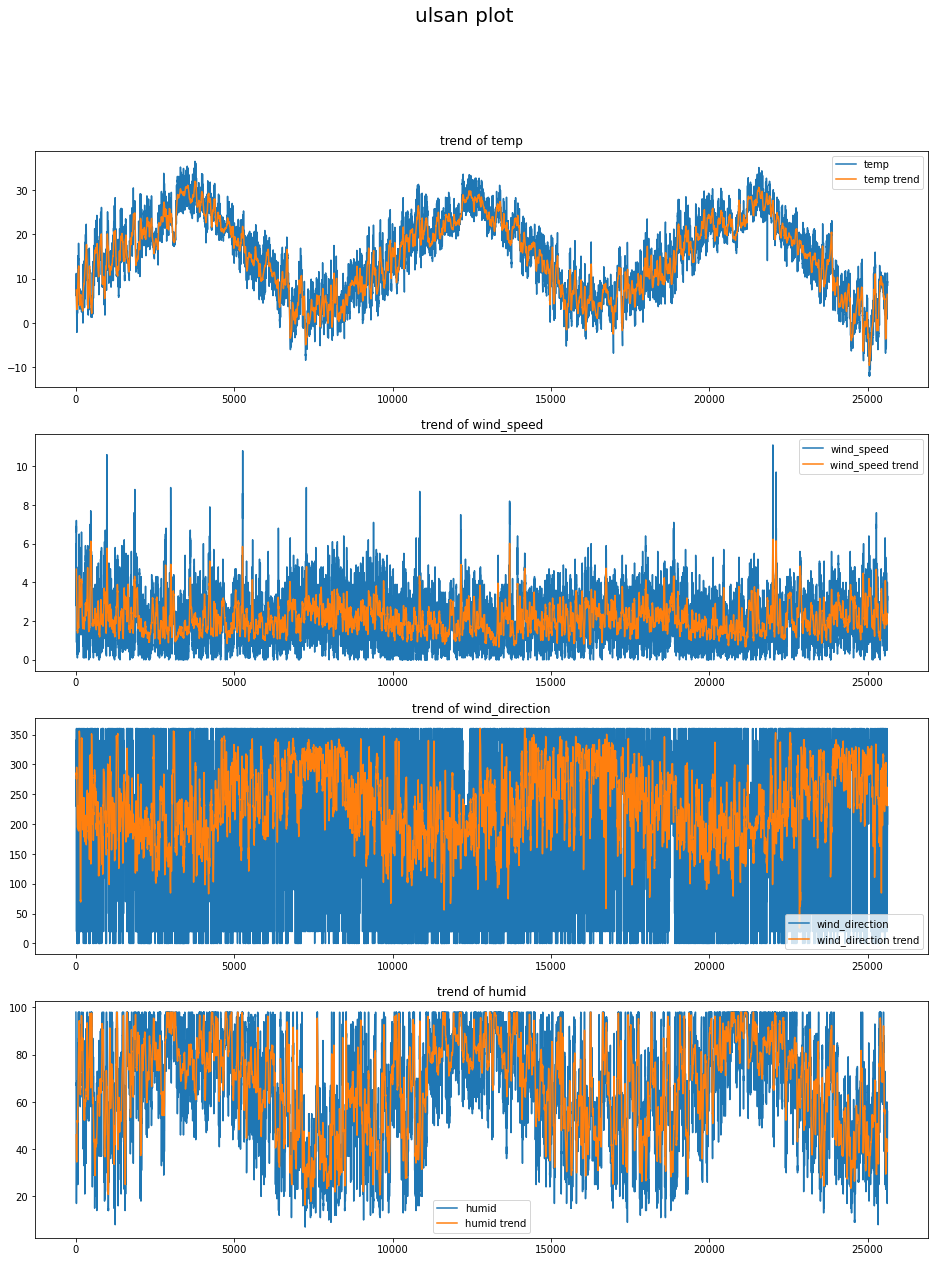

In [16]:
# visualization for whole ulsan weather data 
trend_visualization(u_weather, weather_features, 'ulsan')

## 불필요한 데이터 제거 

'지점'과 '지점명' column은 각각 152, 울산 하나의 value만을 가지므로 향후 데이터를 분류하는데 유의미하게 사용되지는 않는다. 이는 불필요한 리소스를 소모하기도 하고 추가적인 차원으로 인해 학습에 지장이 갈 수 도 있으므로 제거해준다.


## 파생 변수 생성 

본 데이터에서 날짜 및 시간이 'YYYY-mm-dd hh:mm' 포맷으로 통일되어있다. 이는 forecast 데이터 프레임, energy 데이터 프레임에서도 동일하며 분석의 원활함을 위해 'year', 'month', 'day', 'hour'의 파생 변수를 생성해주었다. 파생변수를 생성함으로써   
* 데이터 통합의 원활함
* 연, 월, 일, 시간별 추세 확인   
  
의 추가적인 이점을 기대할 수 있다.


## 결측값 처리

울산 데이터의 경우 "전운량"을 제외하고는 결측치가 크게 확인되지 않았다. 기온, 습도, 풍향에 1개씩 결측치가 확인되었으나, 모두 시계열성을 가지는 수치형 데이터이므로 결측된 시점 t를 기준으로 $\mathbb{E}(data_{t-1}, data_{t+1})$ 으로 이를 대체해주었다.

## 추세 시각화 

시각화 결과, 풍향과 전운량에는 유의미한 트렌드가 관찰되지 않고 무작위성이 강한것을 확인 할 수 있었다.  
그외의 기온, 풍속, 습도는 모두 적절한 추세가 있음을 확인 할 수 있었으나 데이터에 잡음이 너무 많아 smoothing을 해 줄 필요가 있다.  
본 EDA에서는 
* Moving average 
* FFT

를 이용하여 추세를 smoothing하고 그 효과를 비교해보기로 한다.

# 3. LightGBM model

LightGBM을 이용하여 단순 회귀 문제로 접근해보고자 한다. 
t 시점을 예측하기 위한 독립 변수로 
* t-1 ~ t-48시점까지의 energy 데이터 
* t ~ t-48 시점까지의 기상 정보 

를 선정하였다. 

In [17]:
def weather_data_merge(weather, window) :
    for i in range(1, int(window)+1) : 
        shifted_data = weather.shift(i).drop(['year', 'month', 'day', 'hour'], axis=1)
        shifted_data.columns = shifted_data.columns + ['_' + str(i)]*shifted_data.shape[1]
        if i == 1 :
            new_df = weather.merge(shifted_data, left_index=True, right_index=True)
        else : 
            new_df = new_df.merge(shifted_data, left_index=True, right_index=True)
            
    return new_df

def energy_data_merge(energy, place, window) :
    for i in range(1, int(window)+1) : 
            shifted_data = energy[['ulsan']].shift(i)
            if i == 1 :
                new_df = energy[['ulsan']].merge(shifted_data, left_index=True, right_index=True)
            else : 
                new_df = new_df.merge(shifted_data, left_index=True, right_index=True)
                
    new_df.columns = [place] + [place + '_' + str(idx) for idx in range(1, int(window)+1) ]

    return new_df

def make_dataset(weather, energy, window, place, train_ratio) :
    weather_data = weather_data_merge(weather, window)
    energy_data = energy_data_merge(energy, place, window)
    
    data = weather_data.merge(energy_data, left_index=True, right_index=True)
    train, val = data.iloc[ : int(len(data)*train_ratio), :], data.iloc[int(len(data)*train_ratio) : , :]
    
    train_X = train.drop([place], axis=1)
    train_y = train.iloc[: , 445]
    
    val_X = val.drop([place], axis=1).reset_index(drop=True)
    val_y = val.iloc[: , 445].reset_index(drop=True)
    
    return train_X, train_y, val_X, val_y

def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [18]:
train_X, train_y, val_X, val_y = make_dataset(u_weather, energy, 48, 'ulsan', 0.95)

In [19]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [20]:
train_dataset = lgb.Dataset(train_X, train_y)
val_dataset = lgb.Dataset(val_X, val_y)
capacity = 1000
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86201
[LightGBM] [Info] Number of data points in the train set: 24350, number of used features: 493
[LightGBM] [Info] Start training from score 64.504969
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 6.67157	valid_0's score: 1.80024
[1000]	valid_0's l1: 6.20284	valid_0's score: 1.74386
Early stopping, best iteration is:
[1002]	valid_0's l1: 6.20183	valid_0's score: 1.74325


In [21]:
mean_squared_error(ulsan_model.predict(train_X), train_y)

172.82487092653952

In [22]:
mean_squared_error(ulsan_model.predict(val_X), val_y)

214.47645812451924

Text(0.5, 1.0, 'Model prediction')

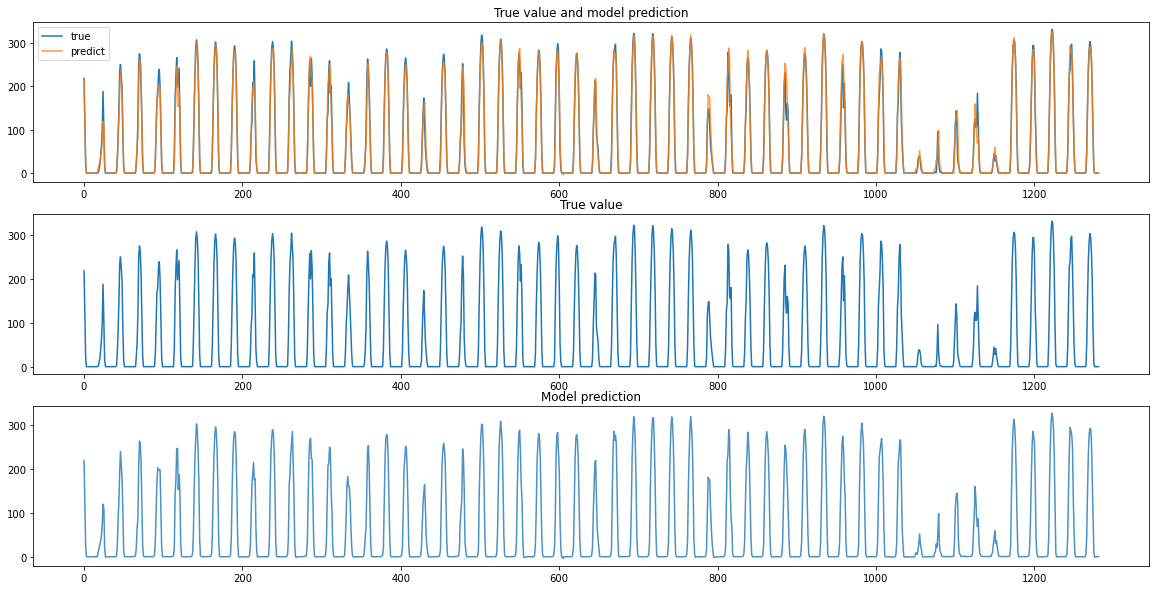

In [23]:
fig, axes = plt.subplots(nrows=3, figsize=(20,10))

axes[0].plot(val_y, label='true')
axes[0].plot(ulsan_model.predict(val_X), alpha=0.8, label='predict')
axes[0].legend()
axes[0].set_title('True value and model prediction')

axes[1].plot(val_y, label='true')
axes[1].set_title('True value')

axes[2].plot(ulsan_model.predict(val_X), alpha=0.8, label='predict')
axes[2].set_title('Model prediction')

In [24]:
feature_importance = pd.DataFrame([val_X.columns, ulsan_model.feature_importance()]).T
feature_importance.columns = ['feature', 'importance']

fi = feature_importance.sort_values(by=['importance'], ascending=False)

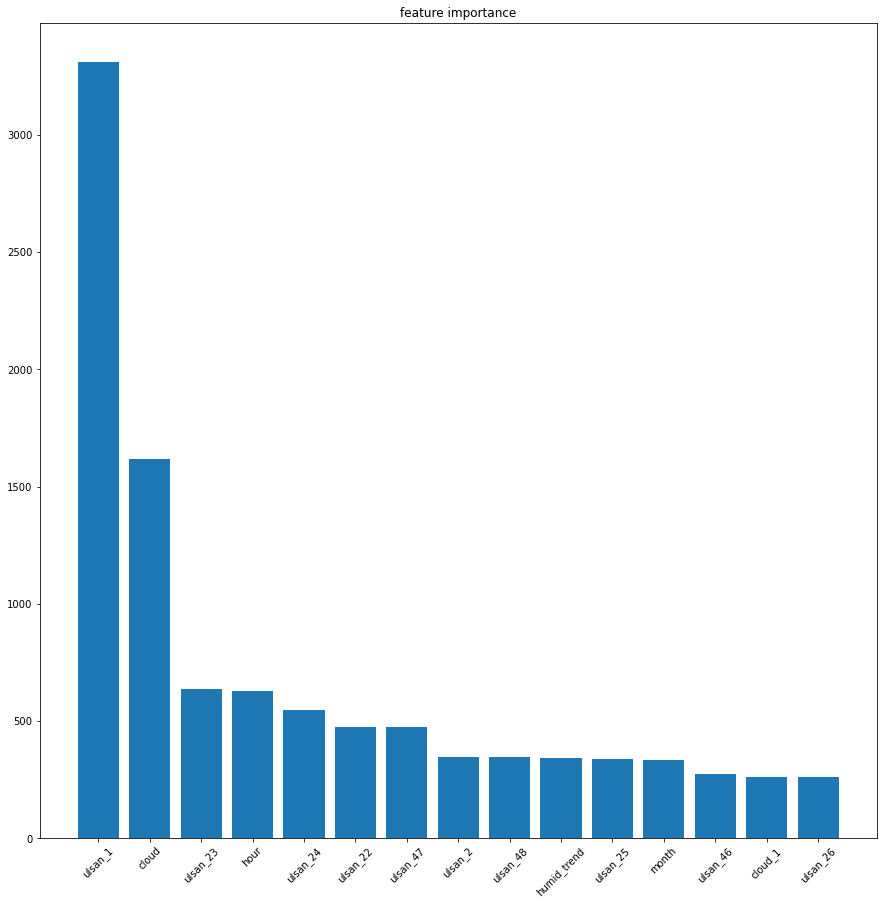

In [25]:
fig, ax = plt.subplots(figsize=(15,15))

ax.bar(fi['feature'][:15], fi['importance'][:15])
ax.set_title('feature importance')
plt.xticks(rotation=45)

plt.show()